In [59]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model 

# from tensorflow.keras.optimizers.legacy import RMSprop

# from tensorflow.keras.optimizers.legacy import Adam

import random

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

## global variables

In [60]:
file_dir = '/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/data/solar_weather copy 2.csv'


time_step = 24
num_feats = 5
evaluation_results = []


neurons = 250

learning_rate_var = 0.005
n_estimators = 100
max_depth = 5

epochs = 10
batch_size = 64

## helper functions

In [61]:
# Modified evaluate_model function to store results in evaluation_results



def evaluate_model(y_true, y_pred, model_name, dataset_type):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Append metrics to evaluation_results
    evaluation_results.append({
        'Model': model_name,
        'Dataset': dataset_type,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

# Step 4: Prepare data for BiLSTM
def create_dataset(dataset, time_step):
    print(f'dataset shape {dataset.shape}')
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]  # Features: GHI and Energy delta
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Target: Energy delta
    return np.array(dataX), np.array(dataY)

def build_bilstm_model(time_step):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(time_step, num_feats))))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(neurons, activation='relu', return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(1)) # output layer
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_learning_curve(history, model_name):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.figure(figsize=(10,6))
  plt.plot(epochs, loss, 'b-', label='Training Loss')
  plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
  plt.title(f'Learning curve: {model_name}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  save_path = os.path.join('/Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/GBDT-BILSTM/assets/learning_curves/multi_variate', f'{model_name}_learning_curve.png')
  plt.savefig(save_path)
  print(f'plot saved to {save_path}')
  plt.show()
  plt.close()

## Base BiLSTM

In [62]:
data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])

# data = data[(data.index.month.isin([6, 7, 8])) & (data.index.year == 2021)]

data = data[(data.index.year == 2021)]

dataset = data[['Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity']]
# dataset = data[['Energy delta[Wh]', 'GHI']]


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

# Function to create sequences with time steps
# def create_dataset(dataset, time_step=1):
def create_dataset(dataset, time_step):
    print(f'dataset shape {dataset.shape}')
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), :]  # Features: GHI and Energy delta
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Target: Energy delta
    return np.array(dataX), np.array(dataY)

# Set time_step (lookback window for BiLSTM)
time_step = 24  # Predict based on past 24 hours (1 day)
X, y = create_dataset(scaled_data, time_step)
print(f'X, y shape {X.shape} {y.shape}')
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_68054/1987844404.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])


dataset shape (34368, 5)
X, y shape (34344, 24, 5) (34344,)


In [63]:
print("Training BiLSTM only...")
print("\n")

model = build_bilstm_model(time_step)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

y_train_predict = scaler.inverse_transform(
    np.concatenate([y_train_predict, X_train[:, -1, 1:]], axis=1)
)[:, 0]

y_test_predict = scaler.inverse_transform(
    np.concatenate([y_test_predict, X_test[:, -1, 1:]], axis=1)
)[:, 0]

y_train_actual = scaler.inverse_transform(
    np.concatenate([y_train.reshape(-1, 1), X_train[:, -1, 1:]], axis=1)
)[:, 0]

y_test_actual = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), X_test[:, -1, 1:]], axis=1)
)[:, 0]

evaluate_model(y_train_actual, y_train_predict, 'BiLSTM', 'Training')
evaluate_model(y_test_actual, y_test_predict, 'BiLSTM', 'Testing')

Training BiLSTM only...


Epoch 1/10
430/430 [==============================] - 53s 117ms/step - loss: 0.0059 - val_loss: 0.0012
Epoch 2/10
430/430 [==============================] - 48s 112ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 3/10
430/430 [==============================] - 50s 117ms/step - loss: 0.0040 - val_loss: 9.8371e-04
Epoch 4/10
430/430 [==============================] - 50s 115ms/step - loss: 0.0039 - val_loss: 9.8357e-04
Epoch 5/10
430/430 [==============================] - 45s 104ms/step - loss: 0.0038 - val_loss: 9.0742e-04
Epoch 6/10
430/430 [==============================] - 44s 102ms/step - loss: 0.0037 - val_loss: 8.6799e-04
Epoch 7/10
430/430 [==============================] - 49s 114ms/step - loss: 0.0038 - val_loss: 9.7118e-04
Epoch 8/10
430/430 [==============================] - 49s 113ms/step - loss: 0.0036 - val_loss: 9.5426e-04
Epoch 9/10
430/430 [==============================] - 49s 114ms/step - loss: 0.0037 - val_loss: 9.2565e-04
Epoch 10/10
215/215

In [64]:
evaluation_results_df = pd.DataFrame(evaluation_results)
bilstm_results = evaluation_results_df[evaluation_results_df['Model'] == 'BiLSTM']
bilstm_results

,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Training,130.862230,82950.527814,288.011333,0.924351
1,BiLSTM,Testing,54.921914,23112.968068,152.029497,0.907768


plot saved to /Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/GBDT-BILSTM/assets/learning_curves/multi_variate/BiLSTM_learning_curve.png


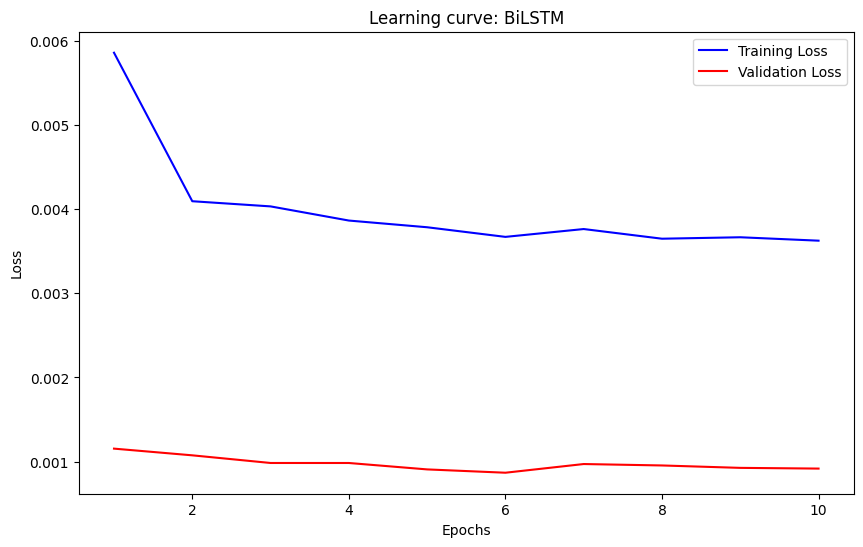

In [65]:
plot_learning_curve(history, 'BiLSTM')

## GBDT-BiLSTM

In [66]:
# Load and split data
data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])

# data = data[(data.index.month.isin([6, 7, 8])) & (data.index.year == 2021)]

data = data[(data.index.year == 2021)]

dataset = data[['Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity']]
# dataset = data[['Energy delta[Wh]', 'GHI']]

X = dataset.iloc[:, 1:].values  # Features
y = dataset.iloc[:, 0].values   # Target

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]




/var/folders/n5/mlsmdgns0kqfybw1r9qm4n5w0000gp/T/ipykernel_68054/3111870226.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_dir, header=0, infer_datetime_format=True, parse_dates=['Time'], index_col=['Time'])


In [67]:
# Step 1: Train GBDT, XGB, and CatBoost on the training data
gbdt = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate_var, max_depth=max_depth)

gbdt.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
gbdt_output_train = gbdt.predict(X_train)
gbdt_output_test = gbdt.predict(X_test)

In [68]:
# Evaluate model performance on training and test sets
evaluate_model(y_train, gbdt_output_train, 'GBDT', 'Training')
evaluate_model(y_test, gbdt_output_test, 'GBDT', 'Testing')

In [69]:


# Step 3: Scale the model outputs
scaler = MinMaxScaler()
gbdt_output_train_scaled = scaler.fit_transform(gbdt_output_train.reshape(-1, 1))
gbdt_output_test_scaled = scaler.transform(gbdt_output_test.reshape(-1, 1))

# Create BiLSTM input for all three model outputs
X_train_bilstm_gbdt, y_train_bilstm_gbdt = create_dataset(gbdt_output_train_scaled, time_step)
X_test_bilstm_gbdt, y_test_bilstm_gbdt = create_dataset(gbdt_output_test_scaled, time_step)

# Reshape X to be (samples, time_steps, features)
X_train_bilstm_gbdt = X_train_bilstm_gbdt.reshape(X_train_bilstm_gbdt.shape[0], time_step, 1)
X_test_bilstm_gbdt = X_test_bilstm_gbdt.reshape(X_test_bilstm_gbdt.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs
print("Training BiLSTM on GBDT outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_gbdt = model.fit(X_train_bilstm_gbdt, y_train_bilstm_gbdt, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_gbdt, y_test_bilstm_gbdt), verbose=1)

# Step 7: Predict with BiLSTM
y_pred_bilstm_gbdt_scaled = model.predict(X_test_bilstm_gbdt)

y_pred_bilstm_gbdt = scaler.inverse_transform(y_pred_bilstm_gbdt_scaled)
y_test_bilstm_gbdt_actual_rescaled = scaler.inverse_transform(y_test_bilstm_gbdt.reshape(-1, 1))

evaluate_model(y_test_bilstm_gbdt_actual_rescaled, y_pred_bilstm_gbdt, 'BiLSTM (GBDT)', 'Testing')

dataset shape (27494, 1)
dataset shape (6874, 1)
Training BiLSTM on GBDT outputs...


Epoch 1/10
430/430 [==============================] - 43s 94ms/step - loss: 0.0053 - val_loss: 6.1403e-04
Epoch 2/10
430/430 [==============================] - 46s 107ms/step - loss: 0.0030 - val_loss: 4.0180e-04
Epoch 3/10
430/430 [==============================] - 46s 107ms/step - loss: 0.0028 - val_loss: 3.2601e-04
Epoch 4/10
430/430 [==============================] - 46s 107ms/step - loss: 0.0027 - val_loss: 3.6019e-04
Epoch 5/10
430/430 [==============================] - 46s 107ms/step - loss: 0.0027 - val_loss: 5.4781e-04
Epoch 6/10
430/430 [==============================] - 46s 106ms/step - loss: 0.0027 - val_loss: 3.2962e-04
Epoch 7/10
430/430 [==============================] - 45s 104ms/step - loss: 0.0027 - val_loss: 3.5297e-04
Epoch 8/10
430/430 [==============================] - 45s 105ms/step - loss: 0.0026 - val_loss: 2.9407e-04
Epoch 9/10
430/430 [==============================] - 46s 1

In [70]:
# Plotting the model architecture

# plot_model(model, to_file='bilstm_gbdt.png', show_shapes=True, show_layer_names=True, dpi=50)


plot saved to /Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/GBDT-BILSTM/assets/learning_curves/multi_variate/BiLSTM-gbdt_learning_curve.png


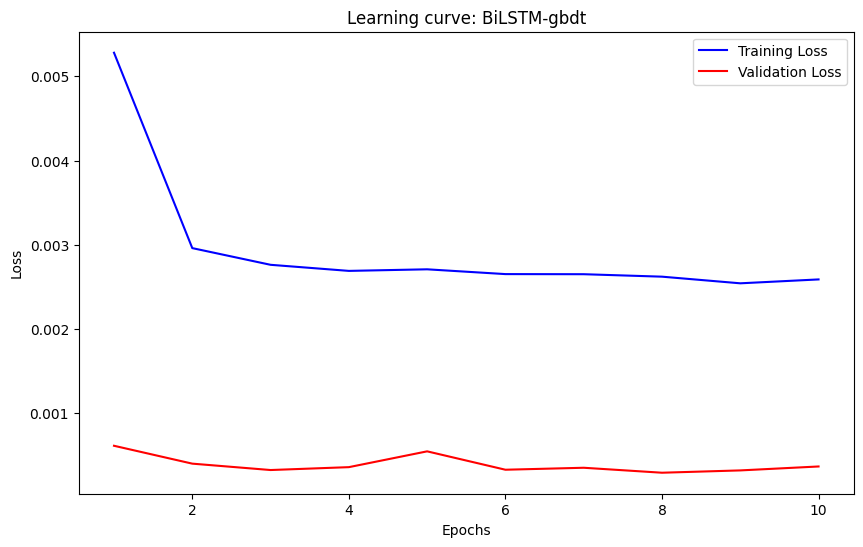

In [71]:
plot_learning_curve(history_gbdt, 'BiLSTM-gbdt')

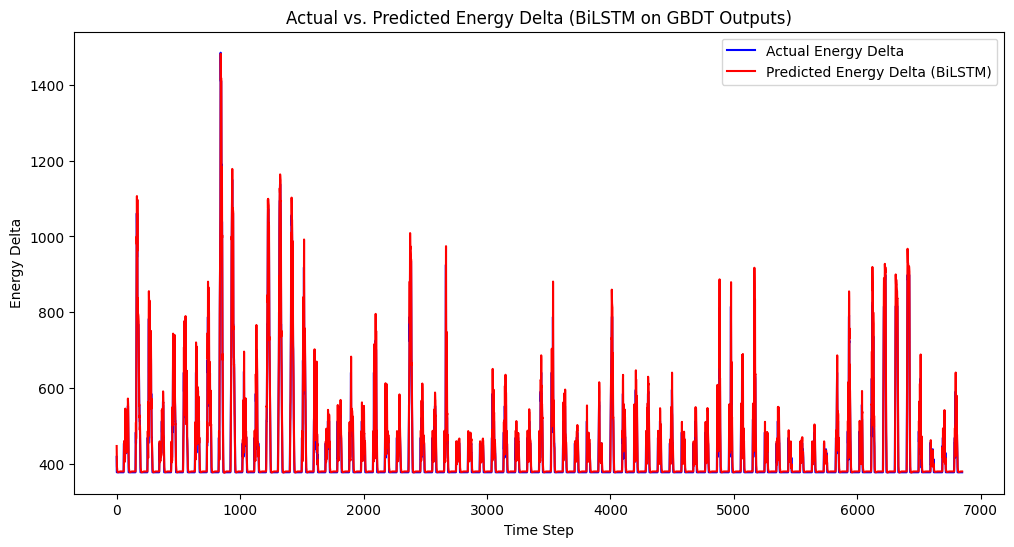

In [72]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_gbdt_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_gbdt, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on GBDT Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [73]:

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 1: Train GBDT, XGB, and CatBoost on the training data

xgb = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate_var, max_depth=max_depth)

xgb.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
xgb_output_train = xgb.predict(X_train)
xgb_output_test = xgb.predict(X_test)

evaluate_model(y_train, xgb_output_train, 'XGB', 'Training')
evaluate_model(y_test, xgb_output_test, 'XGB', 'Testing')

# Step 3: Scale the model outputs
scaler = MinMaxScaler()

xgb_output_train_scaled = scaler.fit_transform(xgb_output_train.reshape(-1, 1))
xgb_output_test_scaled = scaler.transform(xgb_output_test.reshape(-1, 1))


# Create BiLSTM input for all three model outputs

X_train_bilstm_xgb, y_train_bilstm_xgb = create_dataset(xgb_output_train_scaled, time_step)
X_test_bilstm_xgb, y_test_bilstm_xgb = create_dataset(xgb_output_test_scaled, time_step)

X_train_bilstm_xgb = X_train_bilstm_xgb.reshape(X_train_bilstm_xgb.shape[0], time_step, 1)
X_test_bilstm_xgb = X_test_bilstm_xgb.reshape(X_test_bilstm_xgb.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs

print("Training BiLSTM on XGB outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_xgb = model.fit(X_train_bilstm_xgb, y_train_bilstm_xgb, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_xgb, y_test_bilstm_xgb), verbose=1)

# Step 7: Predict with BiLSTM

y_pred_bilstm_xgb_scaled = model.predict(X_test_bilstm_xgb)
y_pred_bilstm_xgb = scaler.inverse_transform(y_pred_bilstm_xgb_scaled)

# Step 8: Evaluate BiLSTM predictions
y_test_bilstm_xgb_actual_rescaled = scaler.inverse_transform(y_test_bilstm_xgb.reshape(-1, 1))

evaluate_model(y_test_bilstm_xgb_actual_rescaled, y_pred_bilstm_xgb, 'BiLSTM (XGB)', 'Testing')

dataset shape (27494, 1)
dataset shape (6874, 1)
Training BiLSTM on XGB outputs...


Epoch 1/10
430/430 [==============================] - 42s 95ms/step - loss: 0.0056 - val_loss: 6.3340e-04
Epoch 2/10
430/430 [==============================] - 46s 107ms/step - loss: 0.0032 - val_loss: 4.3695e-04
Epoch 3/10
430/430 [==============================] - 46s 107ms/step - loss: 0.0030 - val_loss: 3.3151e-04
Epoch 4/10
430/430 [==============================] - 46s 107ms/step - loss: 0.0029 - val_loss: 9.3597e-04
Epoch 5/10
430/430 [==============================] - 46s 106ms/step - loss: 0.0028 - val_loss: 4.3423e-04
Epoch 6/10
430/430 [==============================] - 46s 108ms/step - loss: 0.0027 - val_loss: 4.3669e-04
Epoch 7/10
430/430 [==============================] - 45s 105ms/step - loss: 0.0027 - val_loss: 3.2840e-04
Epoch 8/10
430/430 [==============================] - 47s 109ms/step - loss: 0.0027 - val_loss: 3.3057e-04
Epoch 9/10
430/430 [==============================] - 49s 11

In [74]:
# Plotting the model architecture
# plot_model(model, to_file='bilstm_xgb.png', show_shapes=True, show_layer_names=True, dpi=50)

plot saved to /Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/GBDT-BILSTM/assets/learning_curves/multi_variate/BiLSTM-xgb_learning_curve.png


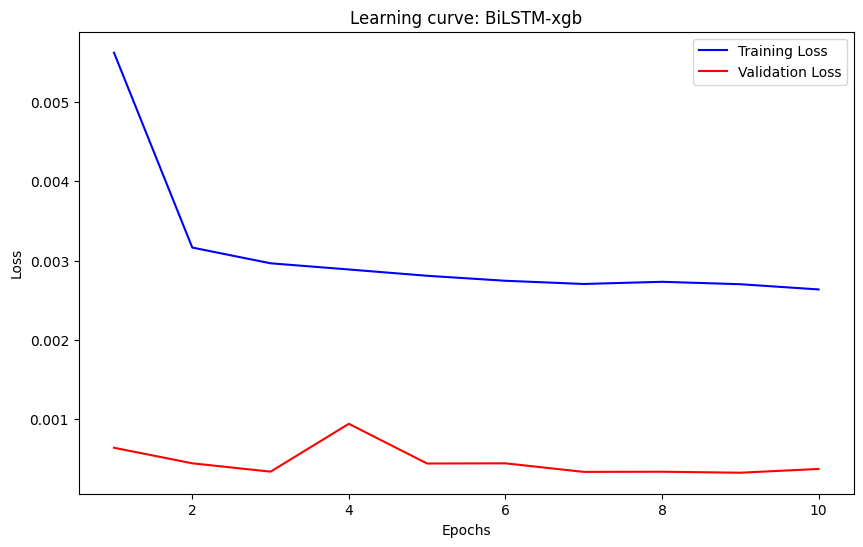

In [75]:
plot_learning_curve(history_xgb, 'BiLSTM-xgb')

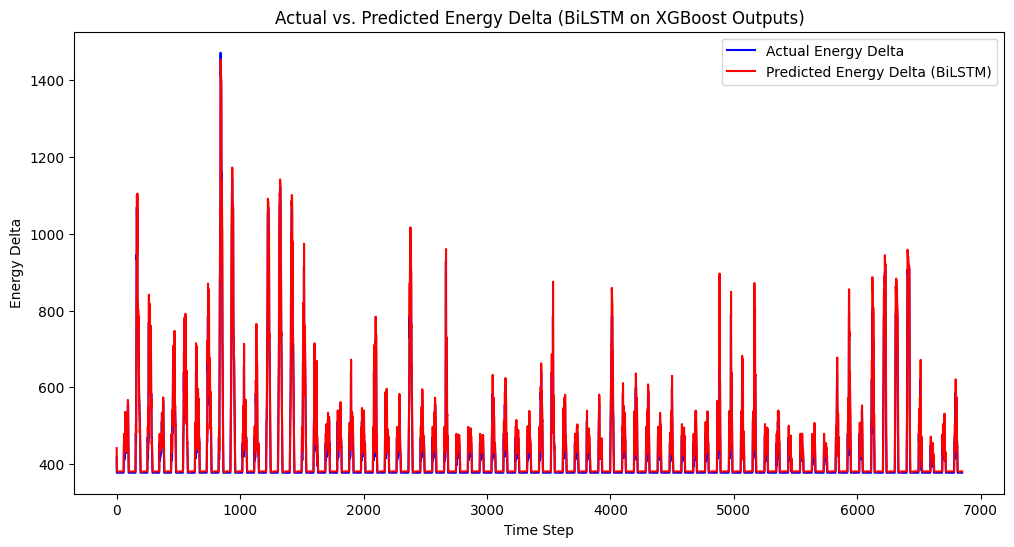

In [76]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_xgb_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_xgb, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on XGBoost Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [77]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 1: Train GBDT, XGB, and CatBoost on the training data
catboost = CatBoostRegressor(n_estimators=n_estimators, learning_rate=learning_rate_var, depth=max_depth)

catboost.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
catboost_output_train = catboost.predict(X_train)
catboost_output_test = catboost.predict(X_test)

# Evaluate model performance on training and test sets 
evaluate_model(y_train, catboost_output_train, 'Catboost', 'Training')
evaluate_model(y_test, catboost_output_test, 'Catboost', 'Testing')

# Step 3: Scale the model outputs
scaler = MinMaxScaler()

catboost_output_train_scaled = scaler.fit_transform(catboost_output_train.reshape(-1, 1))
catboost_output_test_scaled = scaler.transform(catboost_output_test.reshape(-1, 1))

# Create BiLSTM input for all three model outputs
X_train_bilstm_catboost, y_train_bilstm_catboost = create_dataset(catboost_output_train_scaled, time_step)
X_test_bilstm_catboost, y_test_bilstm_catboost = create_dataset(catboost_output_test_scaled, time_step)

X_train_bilstm_catboost = X_train_bilstm_catboost.reshape(X_train_bilstm_catboost.shape[0], time_step, 1)
X_test_bilstm_catboost = X_test_bilstm_catboost.reshape(X_test_bilstm_catboost.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs
print("Training BiLSTM on CatBoost outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_catboost = model.fit(X_train_bilstm_catboost, y_train_bilstm_catboost, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_catboost, y_test_bilstm_catboost), verbose=1)

# Step 7: Predict with BiLSTM
y_pred_bilstm_catboost_scaled = model.predict(X_test_bilstm_catboost)
y_pred_bilstm_catboost = scaler.inverse_transform(y_pred_bilstm_catboost_scaled)

# Step 8: Evaluate BiLSTM predictions
y_test_bilstm_catboost_actual_rescaled = scaler.inverse_transform(y_test_bilstm_catboost.reshape(-1, 1))

evaluate_model(y_test_bilstm_catboost_actual_rescaled, y_pred_bilstm_catboost, 'BiLSTM (CatBoost)', 'Testing')

0:	learn: 1042.6951297	total: 4.02ms	remaining: 398ms
1:	learn: 1038.4490469	total: 5.74ms	remaining: 281ms
2:	learn: 1034.2657120	total: 7.25ms	remaining: 234ms
3:	learn: 1030.0466669	total: 8.87ms	remaining: 213ms
4:	learn: 1025.8807746	total: 10.6ms	remaining: 202ms
5:	learn: 1021.7462333	total: 12.2ms	remaining: 191ms
6:	learn: 1017.5983054	total: 14.1ms	remaining: 187ms
7:	learn: 1013.5192694	total: 15.7ms	remaining: 180ms
8:	learn: 1009.4652657	total: 17.1ms	remaining: 173ms
9:	learn: 1005.4036996	total: 20ms	remaining: 180ms
10:	learn: 1001.3990647	total: 21.5ms	remaining: 174ms
11:	learn: 997.4104730	total: 22.9ms	remaining: 168ms
12:	learn: 993.4142853	total: 24.4ms	remaining: 163ms
13:	learn: 989.4557450	total: 26.1ms	remaining: 160ms
14:	learn: 985.5066014	total: 27.7ms	remaining: 157ms
15:	learn: 981.6343942	total: 29.5ms	remaining: 155ms
16:	learn: 977.7042908	total: 31.1ms	remaining: 152ms
17:	learn: 973.8238774	total: 32.5ms	remaining: 148ms
18:	learn: 969.9524668	total:

In [78]:
# plot_model(model, to_file='bilstm_catboost.png', show_shapes=True, show_layer_names=True, dpi=50)


plot saved to /Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/GBDT-BILSTM/assets/learning_curves/multi_variate/Bilstm-catboost_learning_curve.png


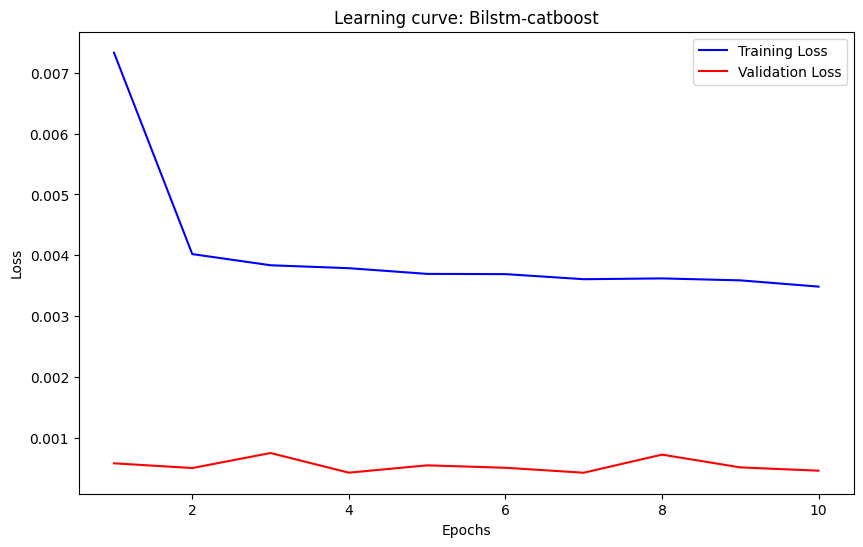

In [79]:
plot_learning_curve(history_catboost, 'Bilstm-catboost')

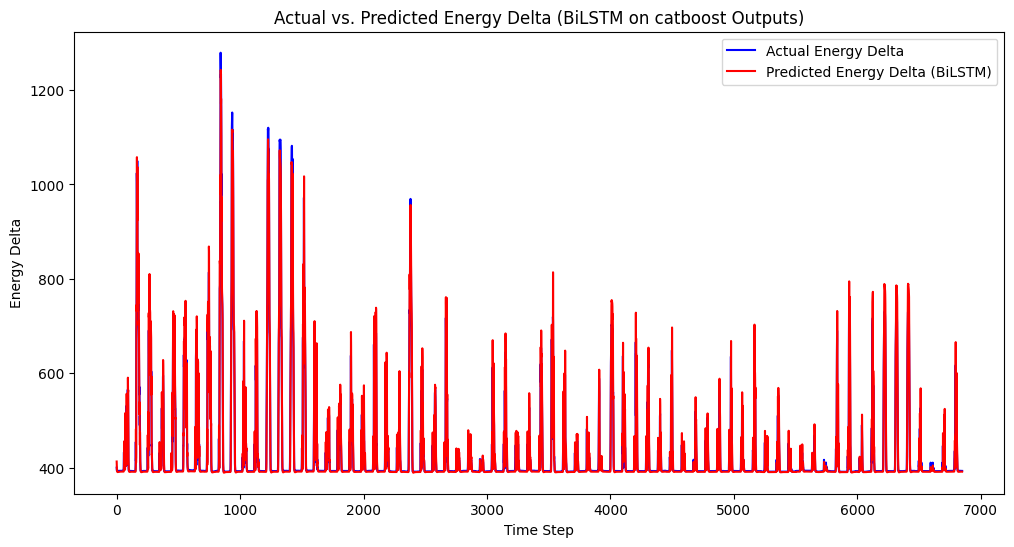

In [80]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_catboost_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_catboost, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on catboost Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [81]:
# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 1: Train GBDT, XGB, and CatBoost on the training data
lgbm = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate_var, max_depth=max_depth)
lgbm.fit(X_train, y_train.ravel())

# Step 2: Get predictions for all models on both training and test sets
lgbm_output_train = lgbm.predict(X_train)
lgbm_output_test = lgbm.predict(X_test)


# Evaluate model performance on training and test sets
evaluate_model(y_train, lgbm_output_train, 'LightGBM', 'Training')
evaluate_model(y_test, lgbm_output_test, 'LightGBM', 'Testing')

# Step 3: Scale the model outputs
scaler = MinMaxScaler()
lgbm_output_train_scaled = scaler.fit_transform(lgbm_output_train.reshape(-1, 1))
lgbm_output_test_scaled = scaler.transform(lgbm_output_test.reshape(-1, 1))

# Create BiLSTM input for all three model outputs
X_train_bilstm_lgbm, y_train_bilstm_lgbm = create_dataset(lgbm_output_train_scaled, time_step)
X_test_bilstm_lgbm, y_test_bilstm_lgbm = create_dataset(lgbm_output_test_scaled, time_step)

# Reshape X to be (samples, time_steps, features)
X_train_bilstm_lgbm = X_train_bilstm_lgbm.reshape(X_train_bilstm_lgbm.shape[0], time_step, 1)
X_test_bilstm_lgbm = X_test_bilstm_lgbm.reshape(X_test_bilstm_lgbm.shape[0], time_step, 1)

# Step 6: Train the BiLSTM model on the three different inputs
print("Training BiLSTM on lightgbm outputs...")
print("\n")

model = build_bilstm_model(time_step)

history_lgbm = model.fit(X_train_bilstm_lgbm, y_train_bilstm_lgbm, epochs=epochs, batch_size=batch_size, validation_data=(X_test_bilstm_lgbm, y_test_bilstm_lgbm), verbose=1)

# Step 7: Predict with BiLSTM
y_pred_bilstm_lgbm_scaled = model.predict(X_test_bilstm_lgbm)
y_pred_bilstm_lgbm = scaler.inverse_transform(y_pred_bilstm_lgbm_scaled)

# Step 8: Evaluate BiLSTM predictions
y_test_bilstm_lgbm_actual_rescaled = scaler.inverse_transform(y_test_bilstm_lgbm.reshape(-1, 1))
evaluate_model(y_test_bilstm_lgbm_actual_rescaled, y_pred_bilstm_lgbm, 'BiLSTM (LightGBM)', 'Testing')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 27494, number of used features: 4
[LightGBM] [Info] Start training from score 622.931512
dataset shape (27494, 1)
dataset shape (6874, 1)
Training BiLSTM on lightgbm outputs...


Epoch 1/10
430/430 [==============================] - 50s 112ms/step - loss: 0.0062 - val_loss: 0.0012
Epoch 2/10
430/430 [==============================] - 46s 107ms/step - loss: 0.0031 - val_loss: 8.9276e-04
Epoch 3/10
430/430 [==============================] - 49s 113ms/step - loss: 0.0029 - val_loss: 4.4529e-04
Epoch 4/10
430/430 [==============================] - 52s 120ms/step - loss: 0.0028 - val_loss: 5.0459e-04
Epoch 5/10
430/430 [==============================] - 44s 102ms/step - loss: 0.0

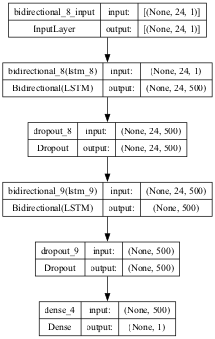

In [82]:
plot_model(model, to_file='bilstm.png', show_shapes=True, show_layer_names=True, dpi=50)

plot saved to /Users/yashwanthkaruparthi/Documents/Acads/sem7/design project/execution/GBDT-BILSTM/assets/learning_curves/multi_variate/BiLSTM-lightgbm_learning_curve.png


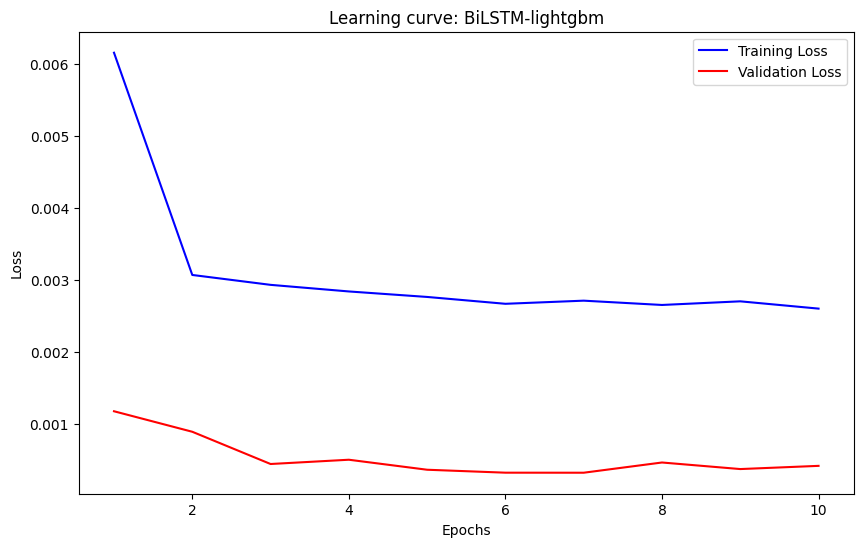

In [83]:
plot_learning_curve(history_lgbm, 'BiLSTM-lightgbm')

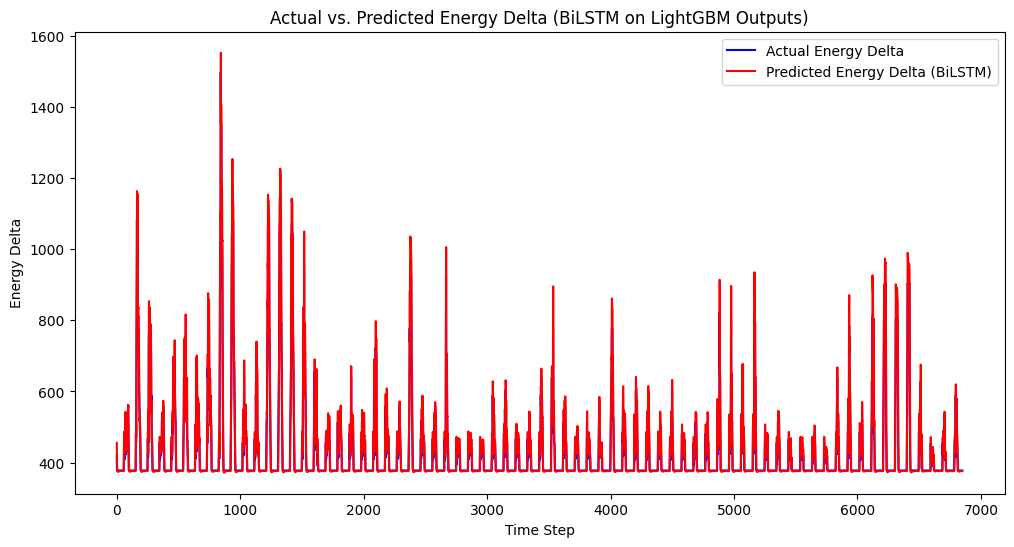

In [84]:
import matplotlib.pyplot as plt

# Step 9: Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_bilstm_lgbm_actual_rescaled, label="Actual Energy Delta", color="blue")
plt.plot(y_pred_bilstm_lgbm, label="Predicted Energy Delta (BiLSTM)", color="red")
plt.title("Actual vs. Predicted Energy Delta (BiLSTM on LightGBM Outputs)")
plt.xlabel("Time Step")
plt.ylabel("Energy Delta")
plt.legend()
plt.show()

In [85]:
results_df = pd.DataFrame(evaluation_results)
print("\nevaluation metrics table: ")


evaluation metrics table: 


In [86]:
results_df

,Model,Dataset,MAE,MSE,RMSE,R²
0,BiLSTM,Training,130.862230,82950.527814,288.011333,0.924351
1,BiLSTM,Testing,54.921914,23112.968068,152.029497,0.907768
2,GBDT,Training,511.771956,492671.132049,701.905358,0.550519
3,GBDT,Testing,410.151436,245226.625415,495.203620,0.020816
4,BiLSTM (GBDT),Testing,13.078780,854.539061,29.232500,0.930532
5,XGB,Training,512.178902,494150.198126,702.958177,0.549169
6,XGB,Testing,410.167285,245188.696675,495.165323,0.020967
7,BiLSTM (XGB),Testing,13.472817,798.498230,28.257711,0.934728
8,Catboost,Training,522.146746,520689.160516,721.587944,0.524957
9,Catboost,Testing,413.671771,248904.402509,498.903200,0.006131


In [87]:
from tensorflow.keras import backend as K
K.clear_session()
